# Result analytics

This notebook will load the result data from approaches and analyze the results and display charts

## Load Data

In [70]:
import pandas as pd
import numpy as np
import os
import gzip
import pickle
from glob import glob
import matplotlib.pyplot as plt

folder = "/data/research/dwa"

In [66]:
# load logs
logs = {}
task_names = None
folder = "/results/res"  # DEBUG: stored in diff folder currently
for file in glob(os.path.join(folder, "*.gzip")):
    exp_name = os.path.splitext(os.path.splitext(os.path.basename(file))[0])[0]
    with gzip.open(file, 'rb') as log_file:
        log = pickle.load(log_file)
    logs[exp_name] = log
    if task_names is None:
        task_names = log["task_name"]
if task_names is None:
    task_names = dict((i, "task {}".format(i+1)) for i in range(100))
        
# load results
results = {}
for file in glob(os.path.join(folder, "*.txt")):
    exp_name = os.path.splitext(os.path.basename(file))[0]
    results[exp_name] = pd.DataFrame(np.loadtxt(file)).rename(columns=task_names)

In [36]:
# show loaded experiments
print("Loaded Experiments ({}):".format(len(results)))
for exp in results:
    print("> {:30}{}".format(exp, " - has log data" if exp in logs else ""))

Loaded Experiments (21):
> mixture_ewc_0_base            
> mixture_ewc_0_curric          
> mixture_ewc_0_lam500           - has log data
> mixture_ewc_0_lam5000          - has log data
> mixture_ewc_0_lam50000         - has log data
> mixture_hat_0_base             - has log data
> mixture_hat_0_curric           - has log data
> mixture_imm-mean_0_base       
> mixture_imm-mode_0_base       
> mixture_joint_0_base          
> mixture_lfl_0_base            
> mixture_lwf_0_base            
> mixture_pathnet_0_base        
> mixture_progressive_0_base    
> mixture_random_0_base         
> mixture_sgd-frozen_0_base     
> mixture_sgd-frozen_0_curric   
> mixture_sgd-restart_0_base    
> mixture_sgd-restart_0_curric  
> mixture_sgd_0_base            
> mixture_sgd_0_curric          


## Plot Results

Plots results and relevant forgetting ratios

In [184]:
# define a name map (defines which objects should be loaded)
exp_map = {
    "mixture_lfl_0_base": "LfL",
    "mixture_lwf_0_base": "LwF"
}
# alternative: pass all names as is (debug)
exp_map = dict(zip(results.keys(), results.keys()))

### Total Results

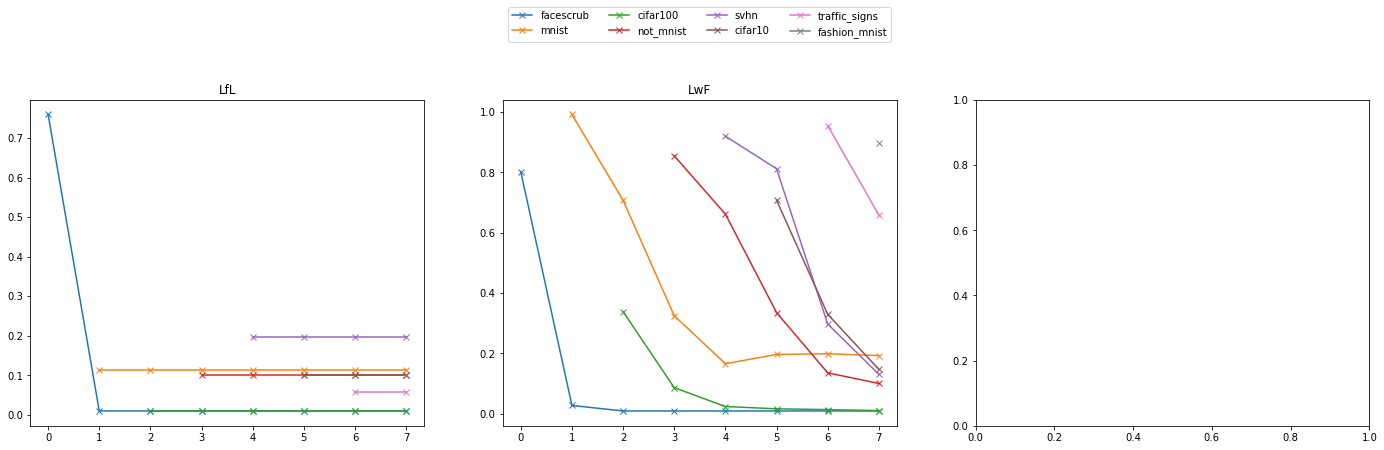

In [169]:
# Plot outcomes
rows = 3
cols = int(np.ceil(len(exp_map) / rows))
fig, axs = plt.subplots(cols, rows, figsize=(8 * rows, 6 * cols))
pos = 0
fltaxs = axs.flatten()
for exp in exp_map:
    ax = fltaxs[pos]
    pos += 1

    results[exp].replace(0, np.NaN).plot.line(marker="x", title=exp_map[exp], ax=ax, legend=None)
        
# generate labels and plot
fltaxs[min(rows // 2, len(exp_map) -1)].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=4)
plt.show()

### Forgetting Ratios

c:\code\envs\research\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


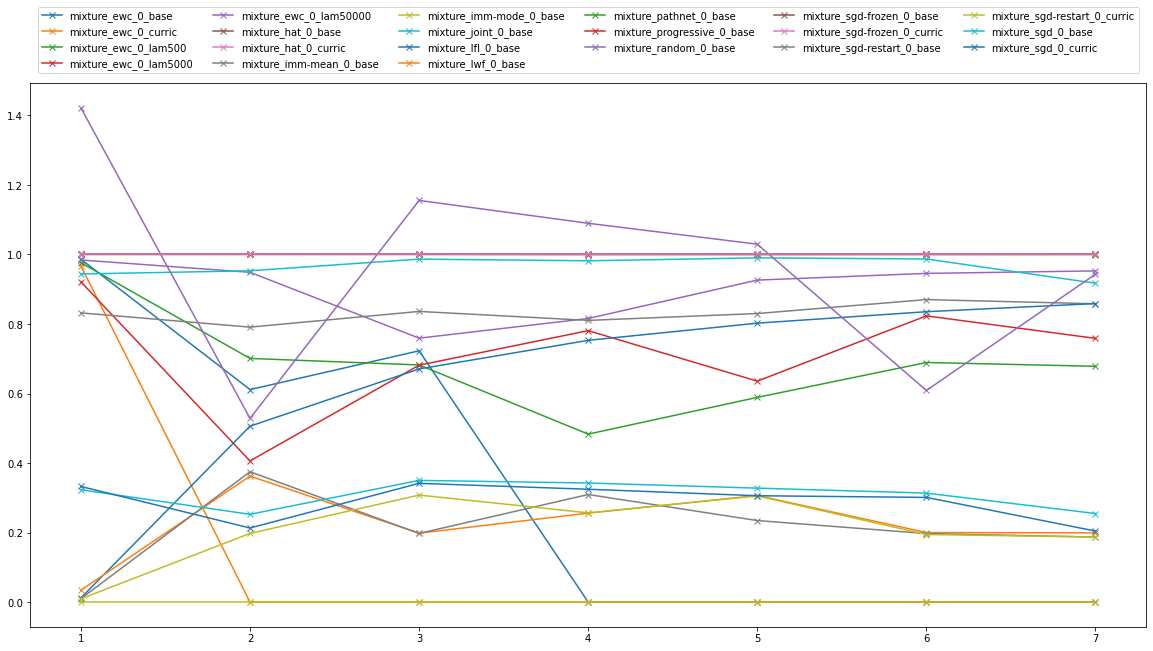

In [197]:
# TODO: compute forget ratio for each approach after each task (then combine)
fr_res = {}
for exp in exp_map:
    data = results[exp]
    
    # compute the forget ratio
    fr = []
    for train_id in range(data.shape[0]):
        task_fr = []
        for task_id in range(train_id):
            task_fr.append((data.iloc[train_id, task_id] / data.iloc[task_id, task_id]))
        fr.append(task_fr)
    fr_res[exp] = pd.DataFrame(fr).mean(axis=1).fillna(0)
    
# gemerate resulting plot
fig, ax = plt.subplots(1, figsize=(20, 10))
pd.DataFrame(fr_res).iloc[1:, :].plot.line(marker='x', ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6)
plt.show()

### Losses

Plot losses for each approach

In [201]:
data = logs['mixture_ewc_0_lam500']
data.keys()

dict_keys(['learning_rate', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc', 'test_loss', 'test_acc', 'task_name'])